In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [0]:
def pdf(x,mu,sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

def plate(x,delta):
    return max(0,1-np.exp(-(x-delta)))

In [0]:
#terminos en cafe
def Pij(pdf,M,T,mu,sigma):
    I=M.shape[0]
    K=T.shape[1]
    P=np.zeros((I,K))
    b=M@T
    for i in range(I):
        for k in range(K):
            P[i,k]=quad(pdf,0,b[i,k],args=(mu[i],sigma[i]))[0]
    return P

def Pjk(pdf,T,t,M,mu,sigma):
    J=T.shape[0]
    L=M.shape[1]
    P=np.zeros((J,L))
    TM=T@M
    muM=mu@M
    sigmaM=sigma@M
    for j in range(J):
        for l in range(L):
            b=t[l]-TM[j,l]
            P[j,l]=quad(pdf,0,b,args=(mu[j,l],sigma[j,l]))[0]
    return P

def clate(t,ts,mu,sigma):
    f = lambda x,delta,mu,sigma:plate(x,delta)*pdf(x,mu,sigma)
    L = t.shape[1]
    c = np.zeros((1,L))
    for i in range(L):
        delta=ts[0,i]-t[0,i]
        c[0,i]=quad(f,delta,np.inf,args=(delta,mu[i],sigma[i]))[0]
    return c

In [0]:
# T y t son las variables
# todo lo demas es constante

I,J,K,L=4,1,1,1

muij=np.array([1,2.5,4,1.8])
sigmaij=np.array([.2,.1,.5,.4])

mujk=np.array([5.5]).reshape(J,K)
sigmajk=np.array([.9]).reshape(J,K)

mukl=np.array([3]).reshape(K,L)
sigmakl=np.array([.2]).reshape(K,L)

In [0]:
W = (np.array([2,5,3,1.5])*1000).reshape(I,1)
wjl = np.array([3000])
wkl = np.array([1000])

Mkl=np.array([1]).reshape(1,1)
Mij=np.ones((4,1))

ts=np.array([12.2]).reshape(1,1)

tp=np.array([0]).reshape(1,1)
Tp=np.array([0]).reshape(1,1)


Penwjk=np.array([1]).reshape(J,K)
Penwkl=np.array([1]).reshape(1,L)

Pensjk=np.array([1]).reshape(1,J)  
Penskl=np.array([1]).reshape(1,K)

Penmkl=np.array([1]).reshape(1,L)
Penmjk=np.array([1]).reshape(1,L)

In [0]:
def G(T,t):
  # parte cafe
  g=(Pij(pdf,Mij,T,muij,sigmaij)@Mkl)*(Mij@Pjk(pdf,T,t,Mkl,mujk,sigmajk))*W
  g= np.ones((1,I))@g
  g+=np.ones((1,J))@(Pjk(pdf,T,t,Mkl,mujk,sigmajk)*wjl)
  g+=wkl
  g=(g@(clate(t,ts,mukl,sigmakl).T)).item()

  # parte roja 
  g+=np.sum((np.where((T-Tp)<0,0,T-Tp)*Penwjk))
  g+=(np.where((t-tp)<0,0,t-tp)@Penwkl).item()
  return g

def H(T,t):
  #parte azul
  h=Pensjk@(Mij.T)@((1-Pij(pdf,Mij,T,muij,sigmaij)@Mkl)*W)
  h=h@(Penmjk.T)
  h+=np.ones((1,I))@((Pij(pdf,Mij,T,muij,sigmaij)@Mkl)*
                     (1-Mij@Pjk(pdf,T,t,Mkl,mujk,sigmajk))*W)
  h+=np.ones((1,J))@((1-Pjk(pdf,T,t,Mkl,mujk,sigmajk))*wjl)@((Penskl@Mkl+Penmkl).T)

  # parte verde
  # no cuenta porque son constantes jejejej 
  return h.item()

In [0]:
# recibe un vector renglon con la matriz aplanada y el vector de forma np.append(T,t)
def k(t):
  T=t[:J*K].reshape(J,K) 
  t=t[-L:].reshape(1,L)
  return G(T,t)+H(T,t)

18359.27664917639


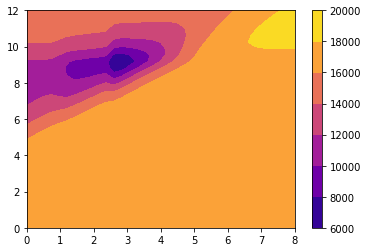

In [8]:
from numpy import ma
from matplotlib import ticker, cm

N = 35
x = np.linspace(0, 8, N)
y = np.linspace(0, 12, N)

X, Y = np.meshgrid(x, y)
z=np.array([k(np.array([x,y])) for x,y in zip(X.flatten(),Y.flatten())]).reshape(X.shape)
print(np.max(z))
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap="plasma")
cbar = fig.colorbar(cs)
plt.show()